# CNN + MaxPool
Try to improve CNN_258.
Address overfitting with dropout layers.

Exclude H1.hESC cell line.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-21 17:32:29.519912


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-21 17:33:05.028876
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4990, 64)          2112      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1246, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1246, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1239, 64)          32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 308, 64)          0         
 1D)                         

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-21 17:33:05.380112
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-21 17:33:15.368220

Training # 1 1
2023-03-21 17:33:15.368392
2023-03-21 17:33:15.368441
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-21 17:33:16.538188


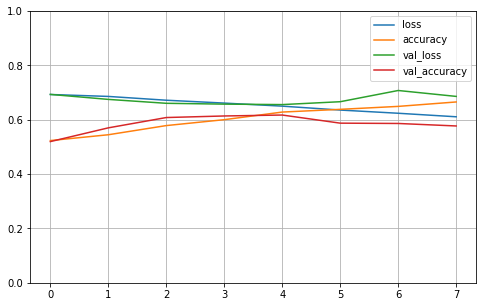


2023-03-21 17:33:39.889995

Testing # 1 1
2023-03-21 17:33:39.890094
2023-03-21 17:33:39.890133
PREDICT
2023-03-21 17:33:40.109635
Test 1:0 458:412 52.64%
Predict 1:0 268:602 30.80%
Test sizes (870, 4997) (870,)
Range of scores: 0.084104225 to 0.8713247
Score threshold 0.5
Confusion matrix
 [[323  89]
 [279 179]]
Normalized matrix
 [[0.37126437 0.10229885]
 [0.32068966 0.20574713]]


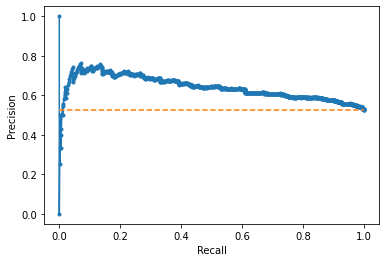

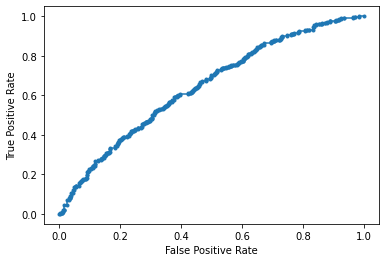

Accuracy: 57.70% Precision: 66.79% Recall: 39.08%
F1: 49.31% MCC: 0.1891
AUPRC: 63.99% AUROC: 64.48%
 accuracy [57.701149425287355]
 precision [66.7910447761194]
 recall [39.082969432314414]
 F1 [49.31129476584023]
 MCC [0.18905260456198414]
 AUPRC [63.99227903074325]
 AUROC [64.47884427862806]
2023-03-21 17:33:41.309184

Training # 1 2
2023-03-21 17:33:41.310292
2023-03-21 17:33:41.310346
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-21 17:33:42.516764


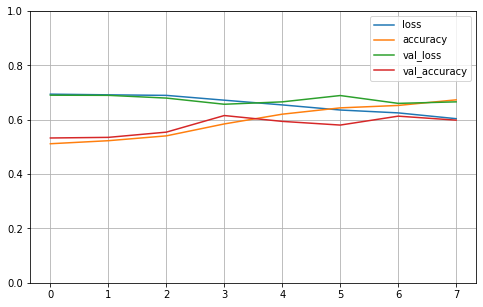


2023-03-21 17:33:56.475181

Testing # 1 2
2023-03-21 17:33:56.475301
2023-03-21 17:33:56.475338
PREDICT
2023-03-21 17:33:56.707684
Test 1:0 442:442 50.00%
Predict 1:0 495:389 56.00%
Test sizes (884, 4997) (884,)
Range of scores: 0.09667966 to 0.9198404
Score threshold 0.5
Confusion matrix
 [[238 204]
 [151 291]]
Normalized matrix
 [[0.26923077 0.23076923]
 [0.17081448 0.32918552]]


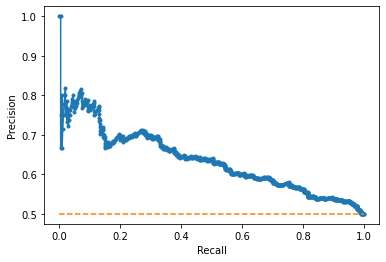

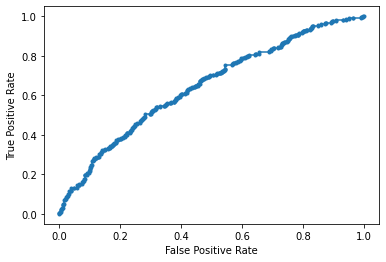

Accuracy: 59.84% Precision: 58.79% Recall: 65.84%
F1: 62.11% MCC: 0.1983
AUPRC: 63.57% AUROC: 64.63%
 accuracy [59.841628959276015]
 precision [58.78787878787879]
 recall [65.83710407239819]
 F1 [62.113127001067234]
 MCC [0.1982630817651787]
 AUPRC [63.56686508809295]
 AUROC [64.62705513810118]
2023-03-21 17:33:57.716126

Training # 1 3
2023-03-21 17:33:57.716292
2023-03-21 17:33:57.716337
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-21 17:33:58.869250


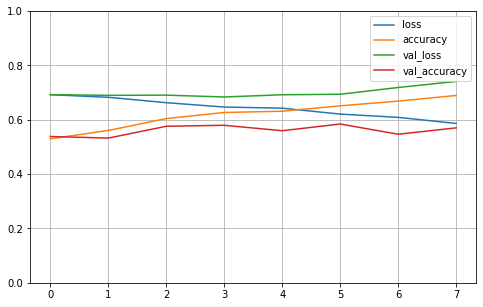


2023-03-21 17:34:21.509306

Testing # 1 3
2023-03-21 17:34:21.510858
2023-03-21 17:34:21.511245
PREDICT
2023-03-21 17:34:21.975538
Test 1:0 442:407 52.06%
Predict 1:0 331:518 38.99%
Test sizes (849, 4997) (849,)
Range of scores: 0.0018505059 to 0.9556396
Score threshold 0.5
Confusion matrix
 [[280 127]
 [238 204]]
Normalized matrix
 [[0.32979976 0.14958775]
 [0.2803298  0.24028269]]


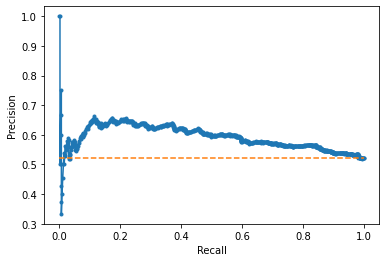

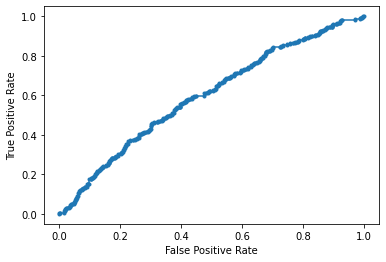

Accuracy: 57.01% Precision: 61.63% Recall: 46.15%
F1: 52.78% MCC: 0.1531
AUPRC: 59.26% AUROC: 59.86%
 accuracy [57.008244994110726]
 precision [61.631419939577036]
 recall [46.15384615384615]
 F1 [52.78137128072446]
 MCC [0.15313278621963608]
 AUPRC [59.25722350758964]
 AUROC [59.86191868544809]
2023-03-21 17:34:23.634127

Training # 1 4
2023-03-21 17:34:23.636292
2023-03-21 17:34:23.638108
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-21 17:34:26.504126


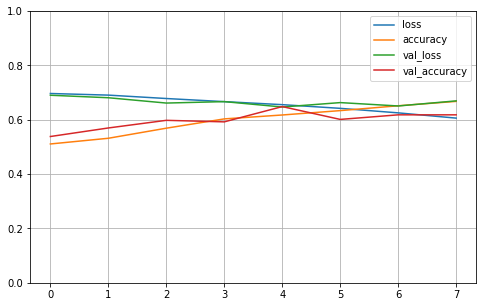


2023-03-21 17:34:41.571898

Testing # 1 4
2023-03-21 17:34:41.575713
2023-03-21 17:34:41.576109
PREDICT
2023-03-21 17:34:42.011765
Test 1:0 459:431 51.57%
Predict 1:0 603:287 67.75%
Test sizes (890, 4997) (890,)
Range of scores: 0.06438128 to 0.95080703
Score threshold 0.5
Confusion matrix
 [[189 242]
 [ 98 361]]
Normalized matrix
 [[0.21235955 0.27191011]
 [0.11011236 0.40561798]]


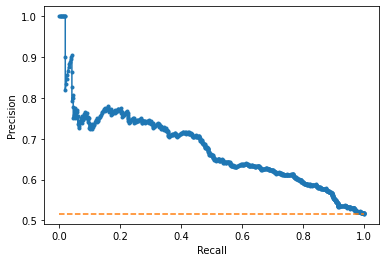

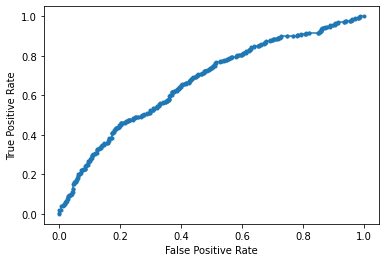

Accuracy: 61.80% Precision: 59.87% Recall: 78.65%
F1: 67.98% MCC: 0.2406
AUPRC: 67.49% AUROC: 66.99%
 accuracy [61.79775280898876]
 precision [59.86733001658375]
 recall [78.64923747276688]
 F1 [67.984934086629]
 MCC [0.24057045118759643]
 AUPRC [67.4871016670185]
 AUROC [66.98815643813596]
2023-03-21 17:34:43.445063

Training # 1 5
2023-03-21 17:34:43.445234
2023-03-21 17:34:43.445280
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-21 17:34:45.235218


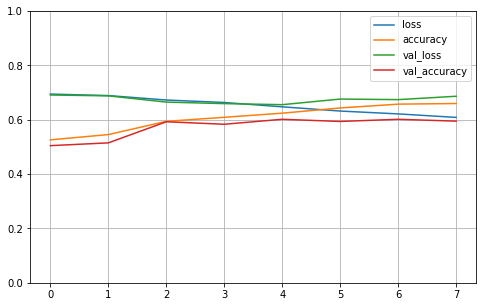


2023-03-21 17:35:06.997133

Testing # 1 5
2023-03-21 17:35:06.997234
2023-03-21 17:35:06.997271
PREDICT
2023-03-21 17:35:07.235556
Test 1:0 457:419 52.17%
Predict 1:0 432:444 49.32%
Test sizes (876, 4997) (876,)
Range of scores: 0.06854608 to 0.96853316
Score threshold 0.5
Confusion matrix
 [[254 165]
 [190 267]]
Normalized matrix
 [[0.28995434 0.18835616]
 [0.21689498 0.30479452]]


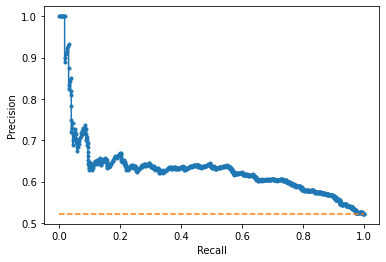

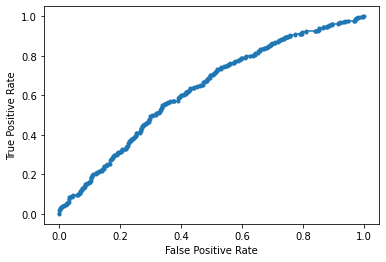

Accuracy: 59.47% Precision: 61.81% Recall: 58.42%
F1: 60.07% MCC: 0.1903
AUPRC: 62.99% AUROC: 62.99%
 accuracy [59.47488584474886]
 precision [61.80555555555556]
 recall [58.42450765864332]
 F1 [60.06749156355456]
 MCC [0.19028890899951778]
 AUPRC [62.98631841548147]
 AUROC [62.98992599865263]
2023-03-21 17:35:08.316585

Training # 2 1
2023-03-21 17:35:08.316780
2023-03-21 17:35:08.316827
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-21 17:35:10.475674


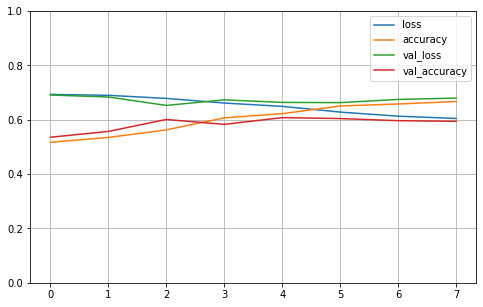


2023-03-21 17:35:32.397559

Testing # 2 1
2023-03-21 17:35:32.397649
2023-03-21 17:35:32.397683
PREDICT
2023-03-21 17:35:32.625531
Test 1:0 472:415 53.21%
Predict 1:0 596:291 67.19%
Test sizes (887, 4997) (887,)
Range of scores: 0.03669678 to 0.92774653
Score threshold 0.5
Confusion matrix
 [[173 242]
 [118 354]]
Normalized matrix
 [[0.19503946 0.27282976]
 [0.13303269 0.39909808]]


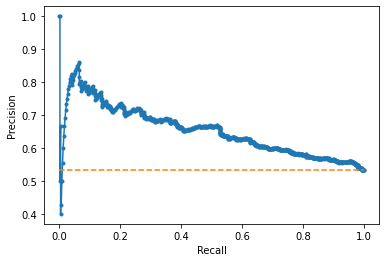

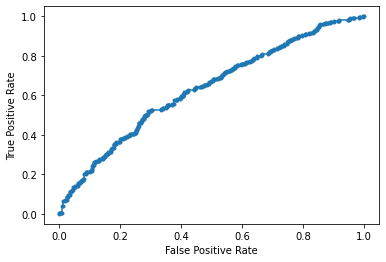

Accuracy: 59.41% Precision: 59.40% Recall: 75.00%
F1: 66.29% MCC: 0.1773
AUPRC: 65.21% AUROC: 63.42%
 accuracy [59.41375422773394]
 precision [59.395973154362416]
 recall [75.0]
 F1 [66.29213483146066]
 MCC [0.17733608005908874]
 AUPRC [65.2148222470681]
 AUROC [63.41841944047376]
2023-03-21 17:35:33.889467

Training # 2 2
2023-03-21 17:35:33.890408
2023-03-21 17:35:33.890456
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-21 17:35:35.759901


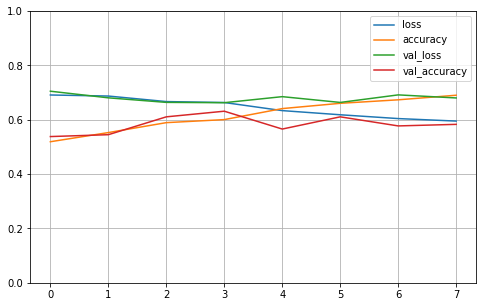


2023-03-21 17:35:50.644553

Testing # 2 2
2023-03-21 17:35:50.646271
2023-03-21 17:35:50.646709
PREDICT
2023-03-21 17:35:50.986993
Test 1:0 452:416 52.07%
Predict 1:0 368:500 42.40%
Test sizes (868, 4997) (868,)
Range of scores: 0.04881855 to 0.9484233
Score threshold 0.5
Confusion matrix
 [[277 139]
 [223 229]]
Normalized matrix
 [[0.31912442 0.16013825]
 [0.25691244 0.26382488]]


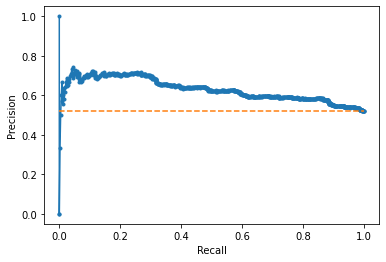

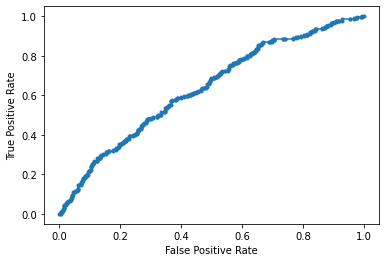

Accuracy: 58.29% Precision: 62.23% Recall: 50.66%
F1: 55.85% MCC: 0.1744
AUPRC: 62.93% AUROC: 63.47%
 accuracy [58.294930875576036]
 precision [62.22826086956522]
 recall [50.66371681415929]
 F1 [55.85365853658537]
 MCC [0.17438233857435037]
 AUPRC [62.92985499017729]
 AUROC [63.47270677331518]
2023-03-21 17:35:52.586024

Training # 2 3
2023-03-21 17:35:52.586194
2023-03-21 17:35:52.586239
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-21 17:35:53.754400


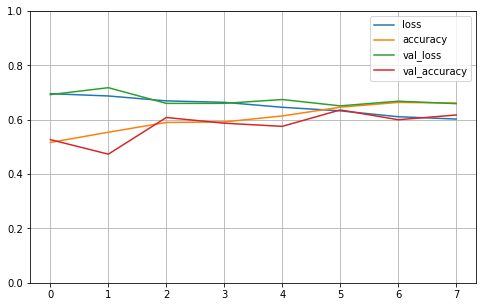


2023-03-21 17:36:07.897100

Testing # 2 3
2023-03-21 17:36:07.897194
2023-03-21 17:36:07.897229
PREDICT
2023-03-21 17:36:08.114887
Test 1:0 453:407 52.67%
Predict 1:0 520:340 60.47%
Test sizes (860, 4997) (860,)
Range of scores: 0.051016707 to 0.94094145
Score threshold 0.5
Confusion matrix
 [[209 198]
 [131 322]]
Normalized matrix
 [[0.24302326 0.23023256]
 [0.15232558 0.3744186 ]]


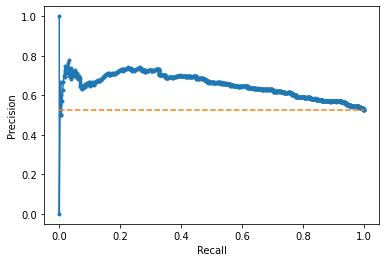

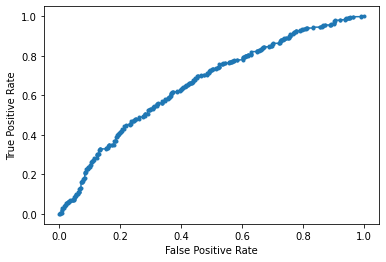

Accuracy: 61.74% Precision: 61.92% Recall: 71.08%
F1: 66.19% MCC: 0.2291
AUPRC: 65.17% AUROC: 65.88%
 accuracy [61.74418604651163]
 precision [61.92307692307693]
 recall [71.08167770419426]
 F1 [66.18705035971223]
 MCC [0.22908312251526577]
 AUPRC [65.17027821401118]
 AUROC [65.8766834263523]
2023-03-21 17:36:09.131345

Training # 2 4
2023-03-21 17:36:09.132821
2023-03-21 17:36:09.132863
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-21 17:36:10.314348


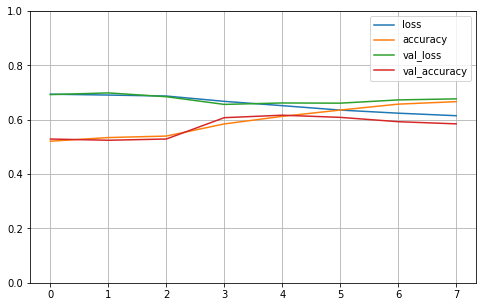


2023-03-21 17:36:32.099961

Testing # 2 4
2023-03-21 17:36:32.100075
2023-03-21 17:36:32.100114
PREDICT
2023-03-21 17:36:32.328706
Test 1:0 432:447 49.15%
Predict 1:0 297:582 33.79%
Test sizes (879, 4997) (879,)
Range of scores: 0.06016324 to 0.92037624
Score threshold 0.5
Confusion matrix
 [[332 115]
 [250 182]]
Normalized matrix
 [[0.37770193 0.13083049]
 [0.28441411 0.20705347]]


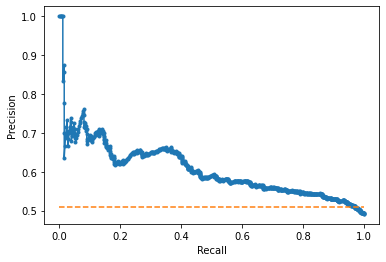

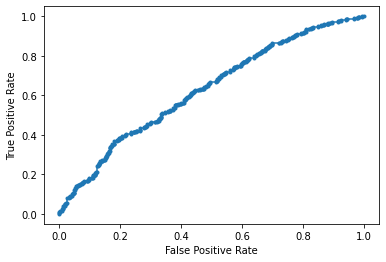

Accuracy: 58.48% Precision: 61.28% Recall: 42.13%
F1: 49.93% MCC: 0.1734
AUPRC: 60.63% AUROC: 62.77%
 accuracy [58.47554038680318]
 precision [61.27946127946128]
 recall [42.129629629629626]
 F1 [49.93141289437585]
 MCC [0.17336744963165263]
 AUPRC [60.629575227290076]
 AUROC [62.76824923357363]
2023-03-21 17:36:33.339214

Training # 2 5
2023-03-21 17:36:33.339384
2023-03-21 17:36:33.339429
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-21 17:36:34.516885


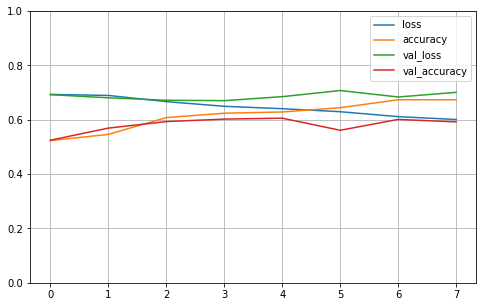


2023-03-21 17:36:48.491543

Testing # 2 5
2023-03-21 17:36:48.491643
2023-03-21 17:36:48.491679
PREDICT
2023-03-21 17:36:48.709214
Test 1:0 449:426 51.31%
Predict 1:0 518:357 59.20%
Test sizes (875, 4997) (875,)
Range of scores: 0.06833588 to 0.9887995
Score threshold 0.5
Confusion matrix
 [[213 213]
 [144 305]]
Normalized matrix
 [[0.24342857 0.24342857]
 [0.16457143 0.34857143]]


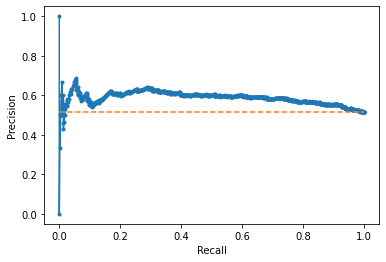

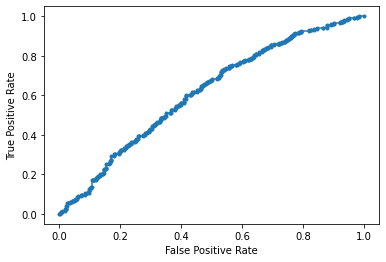

Accuracy: 59.20% Precision: 58.88% Recall: 67.93%
F1: 63.08% MCC: 0.1823
AUPRC: 58.72% AUROC: 61.34%
 accuracy [59.199999999999996]
 precision [58.88030888030889]
 recall [67.92873051224944]
 F1 [63.08169596690797]
 MCC [0.18233856033910026]
 AUPRC [58.72075135788415]
 AUROC [61.34393592438073]
2023-03-21 17:36:49.376144


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 59.30% std 1.57
 precision mean 61.26% std 2.35
 recall mean 59.50% std 14.25
 F1 mean 59.36% std 6.96
 MCC mean 0.19% std 0.03
 AUPRC mean 63.00% std 2.77
 AUROC mean 63.58% std 2.07
 accuracy [[57.701149425287355], [59.841628959276015], [57.008244994110726], [61.79775280898876], [59.47488584474886], [59.41375422773394], [58.294930875576036], [61.74418604651163], [58.47554038680318], [59.199999999999996]]
 precision [[66.7910447761194], [58.78787878787879], [61.631419939577036], [59.86733001658375], [61.80555555555556], [59.395973154362416], [62.22826086956522], [61.92307692307693], [61.27946127946128], [58.88030888030889]]
 recall [[39.082969432314414], [65.83710407239819], [46.15384615384615], [78.64923747276688], [58.42450765864332], [75.0], [50.66371681415929], [71.08167770419426], [42.129629629629626], [67.92873051224944]]
 F1 [[49.31129476584023], [62.113127001067234], [52.78137128072446], [67.984934086629], [60.06749156355456], [66.29213483146066], [55.8536585365